In [104]:
import torch
import deeplake
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [105]:
ds = deeplake.load(("hub://sinzlab/imagenet_and_responses_5M"))

\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/imagenet_and_responses_5M



/

hub://sinzlab/imagenet_and_responses_5M loaded successfully.



In [109]:
from tqdm import tqdm
n_images = 100_000
resps = []
for i, sample in tqdm(enumerate(ds)):
    if i == 100_000:
        break
    resps.append(sample.responses.numpy())


100000it [01:16, 1304.86it/s]


In [110]:
resps = np.stack(resps)

In [ ]:
from lib.nnvision.nnvision.models.trained_models.v4_task_driven import task_driven_ensemble_1

task_driven_ensemble_1

In [133]:
from lib.nnvision.nnvision.models.trained_models.v4_data_driven import (
    v4_multihead_attention_ensemble_model,
)

v4_multihead_attention_ensemble_model.eval()

tform = transforms.Compose(
    [
        transforms.ToTensor(),  # Must convert to pytorch tensor for subsequent operations to run
        transforms.Normalize(
            [0.4876],
            [
                0.2756,
            ],
        ),  # images are grayscale, mean and std are taken from our actual monkey data
    ]
)

# neuron_idx = np.load("../data/pretrained_resnet_unit_correlations.npy").argsort()[::-1][:150]
neuron_idx = menis['unit_idx'].unique() #np.load("../data/data_driven_corr.npy").argsort()[:150]
n_top_images = 5

img_indices = np.array(
    [np.argsort(resps[:, i])[-n_top_images:] for i in neuron_idx]
)

# responses = [torch.Tensor(ds.responses[int(i)].numpy()) for i in img_indices]
# responses = [r[i] for r, i in zip(responses, neuron_idx)]

images = torch.stack([tform(ds.images[int(i)].numpy()) for i in img_indices.flatten()])

images = images.reshape(len(neuron_idx), n_top_images, 1, 100, 100)
# scores = []
# for i, n in zip(images, neuron_idx):
#     score = v4_multihead_attention_ensemble_model(
#         i.unsqueeze(0), data_key="all_sessions"
#     )[:, n].item()
#
#     scores.append(score)

In [134]:
norm_images = images + 1.8 / 3.6
norm_images = norm_images.repeat(1, 1, 3, 1, 1)

norm_images.shape

torch.Size([90, 5, 3, 100, 100])

In [ ]:
from torchmetrics.image.fid import FrechetInceptionDistance

In [ ]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns

def get_result(run_id, unit_idx):
    api = wandb.Api()
    run = api.run(f"sinzlab/egg/{run_id}")
    history = run.history()

    dime = history.query(f"unit_idx == {unit_idx}")

    # download image
    filename = dime.image[0]["path"]
    file = run.file(filename)
    filename = file.download(exist_ok=True).name
    image = Image.open(filename)
    image = np.array(image)

    return image, dime.train[0]


def get_scores(run_id):
    api = wandb.Api()
    run = api.run(f"sinzlab/egg/{run_id}")
    history = run.history(samples=2000)

    return history

api = wandb.Api()
menis = get_scores("pga7ddwq")
run = api.run(f"sinzlab/egg/pga7ddwq")

# idx = history.groupby(["unit_idx", "energy_scale"])["val"].idxmin()
# menis = history.loc[
#     idx, ["seed", "energy_scale", "unit_idx", "train", "val", "cross-val", "image"]
# ]

In [ ]:
ims = {}

In [ ]:
import torch.nn.functional as F

def get_image(filename):
    file = run.file(filename)
    filename = file.download(exist_ok=True).name
    img = Image.open(filename)
    img = np.array(img)
    img = img / 255
    img = torch.Tensor(img)
    img = img.permute(2, 0, 1).unsqueeze(0)#.repeat(2, 1, 1, 1)

    img = F.interpolate(
            img, size=(100, 100), mode="bilinear", align_corners=False
        )

    return img

FID = []
for n_idx in tqdm(range(150)):
    score = []
    for i in [10, 5, 2, 1]:
        images = menis.query(f'unit_idx == {neuron_idx[n_idx]}').query(f'energy_scale == {i}')
        images = torch.cat([get_image(image['image']['path']) for idx, image in images.iterrows()])

        fid = FrechetInceptionDistance(feature=64, normalize=True)
        fid.update(norm_images[n_idx], real=True)
        fid.update(images, real=False)
        score.append(fid.compute())
    FID.append(score)
#
# FID

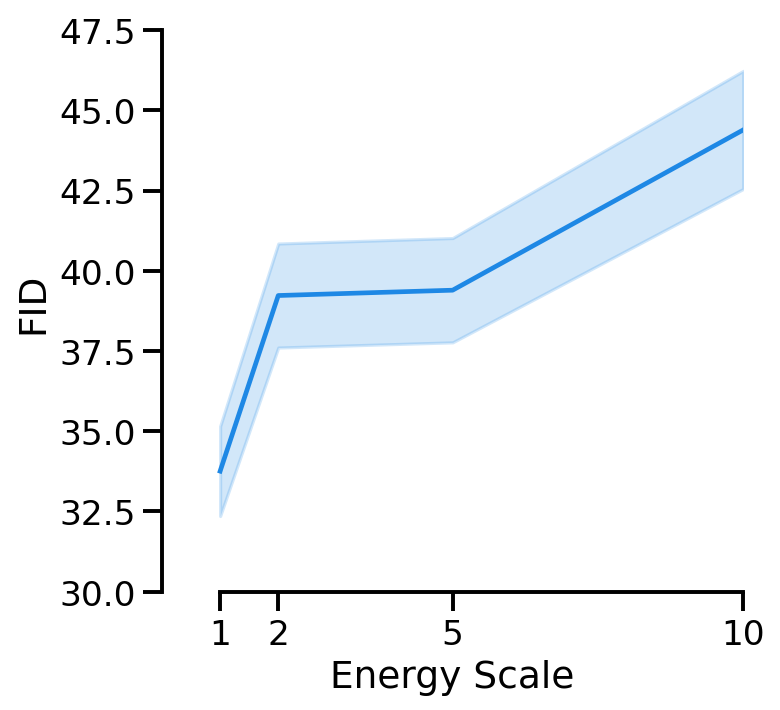

In [144]:
from egg.palettes import palettes
mu = np.array(FID).mean(0)
se = np.array(FID).std(0) / np.sqrt(len(FID))
x = [10, 5, 2, 1]

plt.style.use("default")
sns.set_context('talk')
plt.figure(figsize=(5, 5), dpi=150)
plt.plot(x, mu, color=palettes["candy"]["blue"])
plt.fill_between(x, mu - se, mu + se, color=palettes["candy"]["blue"], alpha=0.2)

plt.xticks([1, 2, 5, 10])

plt.ylim(30, 48)
plt.xlim(0, 10)

plt.xlabel("Energy Scale")
plt.ylabel("FID")
# plt.title("FID vs Energy Scale")

sns.despine(trim=True)
plt.savefig('./fid.png', dpi=150, bbox_inches='tight')
plt.show()

In [136]:
import torch.nn.functional as F

def get_image(filename):
    file = run.file(filename)
    filename = file.download(exist_ok=True).name
    img = Image.open(filename)
    img = np.array(img)
    img = img / 255
    img = torch.Tensor(img)
    img = img.permute(2, 0, 1).unsqueeze(0)#.repeat(2, 1, 1, 1)

    img = F.interpolate(
            img, size=(100, 100), mode="bilinear", align_corners=False
        )

    return img

api = wandb.Api()
menis = get_scores("st6ym3wn")
run = api.run(f"sinzlab/egg/st6ym3wn")

FID_dd = []
for n_idx in tqdm(range(90)):
    score = []
    for i in [10, 5, 2, 1]:
        images = menis.query(f'unit_idx == {neuron_idx[n_idx]}').query(f'energy_scale == {i}')
        images = torch.cat([get_image(image['image']['path']) for idx, image in images.iterrows()])

        fid = FrechetInceptionDistance(feature=64, normalize=True)
        fid.update(norm_images[n_idx], real=True)
        fid.update(images, real=False)
        score.append(fid.compute())
    FID_dd.append(score)

100%|██████████| 90/90 [20:13<00:00, 13.48s/it]


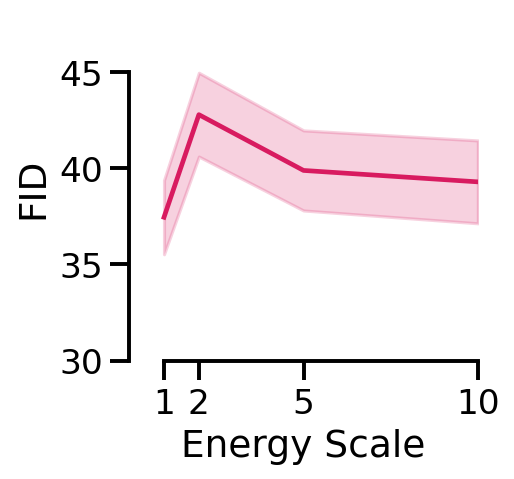

In [139]:
from egg.palettes import palettes
mu = np.array(FID_dd).mean(0)
se = np.array(FID_dd).std(0) / np.sqrt(len(FID))
x = [10, 5, 2, 1]

plt.style.use("default")
sns.set_context('talk')
plt.figure(figsize=(3, 3), dpi=150)
plt.plot(x, mu, color=palettes["candy"]["pink"])
plt.fill_between(x, mu - se, mu + se, color=palettes["candy"]["pink"], alpha=0.2)

plt.xticks([1, 2, 5, 10])

plt.ylim(30, 48)
plt.xlim(0, 10)

plt.xlabel("Energy Scale")
plt.ylabel("FID")
# plt.title("FID vs Energy Scale")

sns.despine(trim=True)
# plt.savefig('./fid.png', dpi=150, bbox_inches='tight')
plt.show()

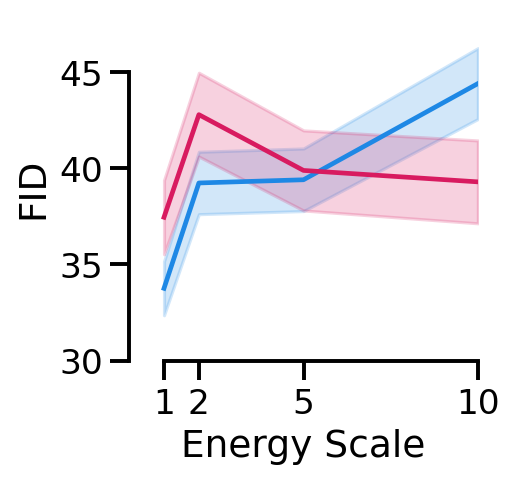

In [140]:
from egg.palettes import palettes
mu = np.array(FID).mean(0)
se = np.array(FID).std(0) / np.sqrt(len(FID))
mu_dd = np.array(FID_dd).mean(0)
se_dd = np.array(FID_dd).std(0) / np.sqrt(len(FID))
x = [10, 5, 2, 1]

plt.style.use("default")
sns.set_context('talk')
plt.figure(figsize=(3, 3), dpi=150)
plt.plot(x, mu, color=palettes["candy"]["blue"])
plt.fill_between(x, mu - se, mu + se, color=palettes["candy"]["blue"], alpha=0.2)

plt.plot(x, mu_dd, color=palettes["candy"]["pink"])
plt.fill_between(x, mu_dd - se_dd, mu_dd + se_dd, color=palettes["candy"]["pink"], alpha=0.2)

plt.xticks([1, 2, 5, 10])

plt.ylim(30, 48)
plt.xlim(0, 10)

plt.xlabel("Energy Scale")
plt.ylabel("FID")
# plt.title("FID vs Energy Scale")

sns.despine(trim=True)
plt.savefig('./fid.png', dpi=150, bbox_inches='tight')
plt.show()

In [124]:
menis

[ 964   37 1184  821 1124 1088  127 1108  205  220   40   22  320 1145
 1094  501  753 1025 1217   49  677  240  217 1146  241  509   84    8
   23  128 1213  771  371   90  411 1024  998  325  778   93 1160   94
  536 1109    9  157  425  156  832  237  331  166 1155 1153  324  202
  130   83  164  289    5 1046  814 1221  637 1173  780  963  517  287
 1157  782  790 1176  286  981  900 1093  946   11  234  747 1137   99
  356  546  685  251  758  426  161 1034  115  658  391 1074  434  185
   39  432  572  933 1111 1178  809 1192   29 1032  135  106  410  995
  573 1112  883  108  222  507  831  123 1119 1177  980 1179  881 1017
  600  236  219 1068  773  327  819  943  177  150  835 1150  997  775
   95  759  876  556  381  971  633  796  500  899]


In [118]:
menis.query('unit_idx == 821')

,image,unit_idx,_timestamp,val,_step,train,_runtime,cross-val,energy_scale,seed
